# Advanced Lane Finding Project

The goals of this project are:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [3]:
# Import all the required packages
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration and Undistortion
Calibration is done by first reading through a list of images and calculate the distortion coefficients and then applying the undistortion function on the targeted image. 

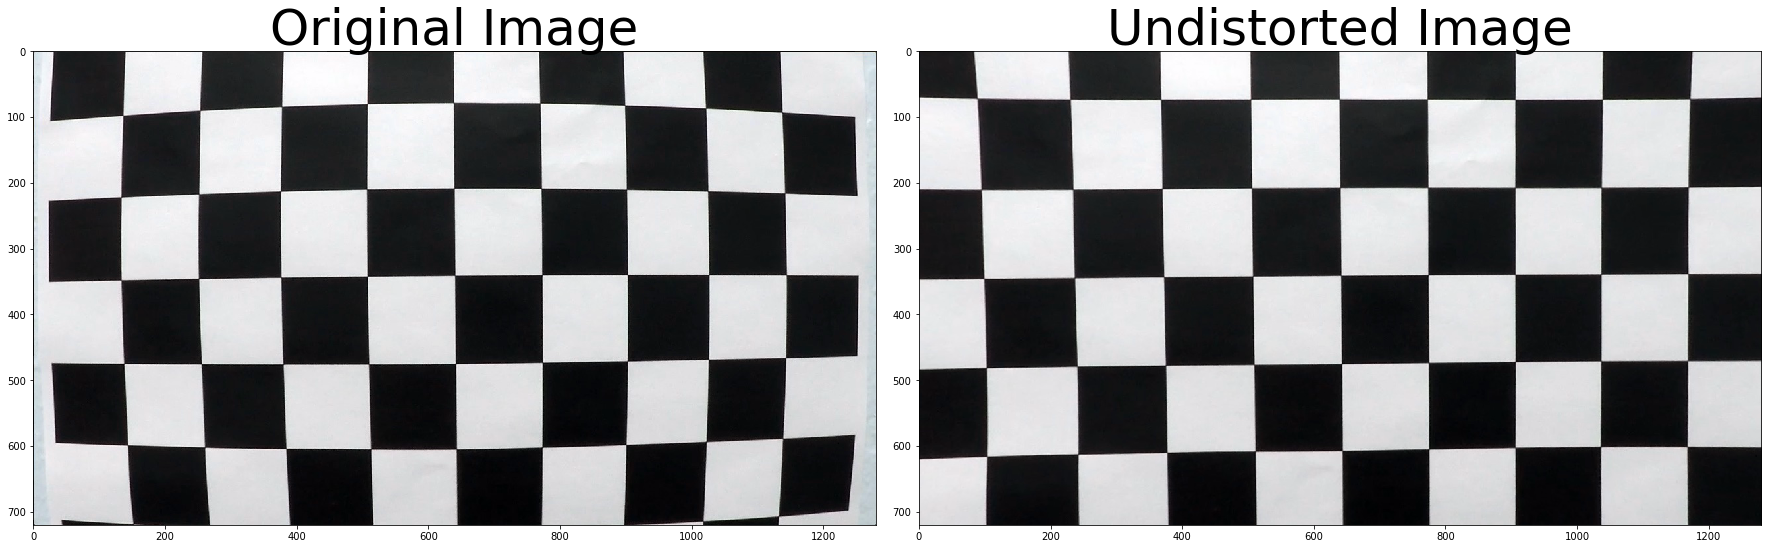

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9# The number of inside corners in x
ny = 6# The number of inside corners in y

objpoints = []
imgpoints = []

# Prepare object points as in 3-dimensions (0, 0, 0), (1, 0, 0), (2, 0, 0)...(8, 5, 0)
# Here we have 54 points, each with 3 coordinates.
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)

#         cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)

# mtx, and dist will be used to undistort an image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

#  Test undistortion function
img = cv2.imread(images[0])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Try on a road image
We can see that the undistortion is applied if we pay attention to the pixels at around 300 on the x axis. The mountain line is slightly moved up after undistortion.

Text(0.5,1,'Undistorted Image')

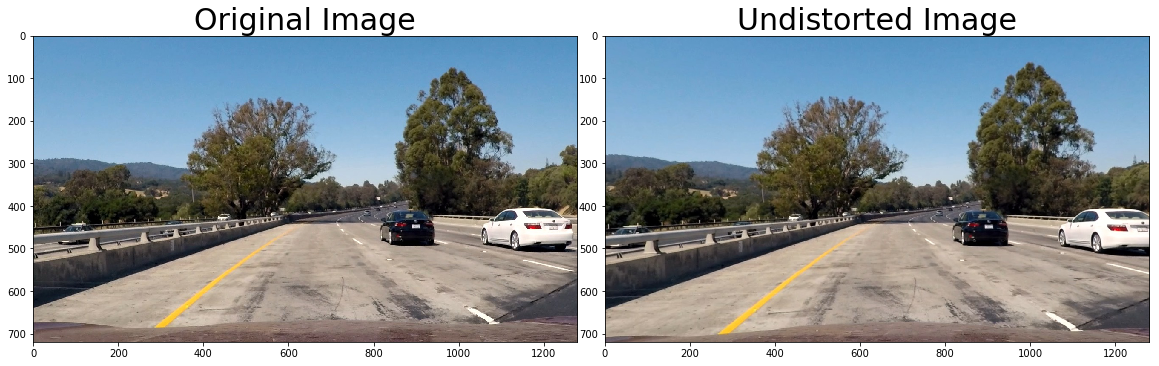

In [11]:
# Try on a road image
example_img = cv2.imread('./test_images/test1.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
undistorted_example_img = cv2.undistort(example_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_example_img)
ax2.set_title('Undistorted Image', fontsize=30)

## Lane Curvature Extraction
### Create threshold binary image

#### Using Sobel Gradient thresholding


In [54]:
def abs_sobel_threshing_one_axis(img, orient = 'x', threshold = (0, 255), sobel_kernel_size = 3):
    # Grayscale
    # Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). 
    # Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread(), which we are using.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel_size)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel_size)
    else:
        raise ValueError('Invalid option on orientation ' + orient)
    
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply lower and upper thresholds
    sbinary = np.zeros_like(scaled_sobel)
    
    # Create binary_output
    sbinary[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return sbinary

def sobel_magnitude_thresholding(img, sobel_kernel_size = 3, magnitude_threshold = (0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8)
    
    # Create binary_output
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= magnitude_threshold[0]) & (magnitude <= magnitude_threshold[1])] = 1
    
    return binary_output

def sobel_direction_thresholding(img, sobel_kernel_size = 3, direction_threshold=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel_size)
    # Take the absolute values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create binary_output
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= direction_threshold[0]) & (direction <= direction_threshold[1])] = 1
    
    return binary_output

#### Testing on the road images
We can see that for this image, the combination of gradient threshold can produce a good result. 

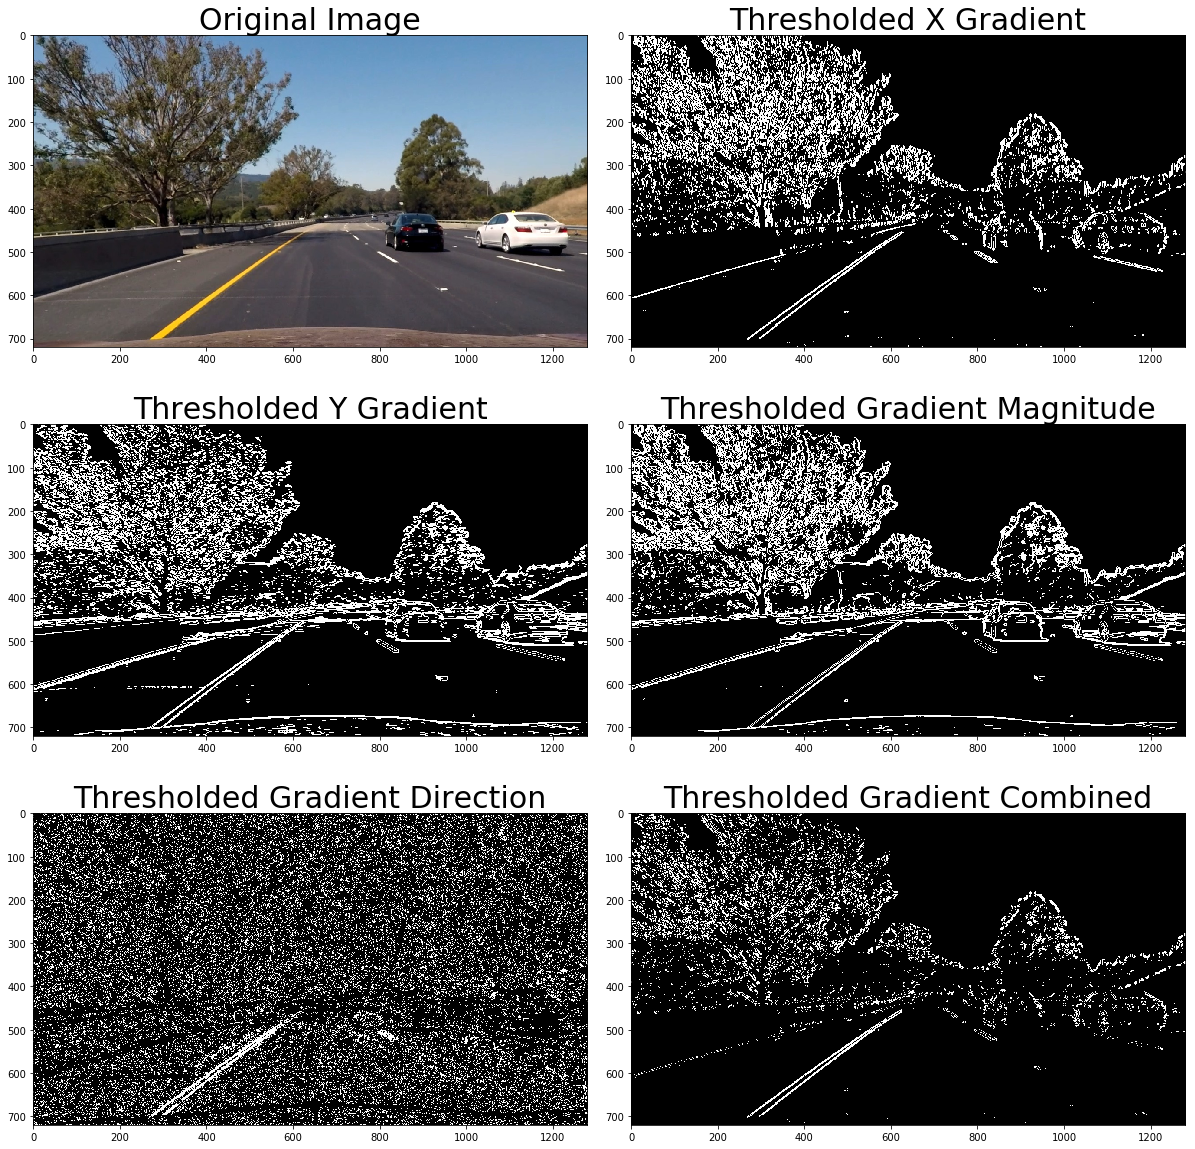

In [55]:
example_img = cv2.imread('./test_images/test6.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
undistorted_example_img = cv2.undistort(example_img, mtx, dist, None, mtx)

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Run the function
grad_binary_x = abs_sobel_threshing_one_axis(undistorted_example_img, orient='x', sobel_kernel_size=ksize, threshold = (20,100))
grad_binary_y = abs_sobel_threshing_one_axis(undistorted_example_img, orient='y', sobel_kernel_size=ksize, threshold = (20,100))
mag_binary = sobel_magnitude_thresholding(undistorted_example_img, sobel_kernel_size=ksize, magnitude_threshold=(30, 100))
dir_binary = sobel_direction_thresholding(undistorted_example_img, sobel_kernel_size=ksize, direction_threshold=(0.8, 1.1))


# Combining them together
combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined[((grad_binary_x == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1


# Plot the result
f, axs = plt.subplots(3, 2, figsize=(16, 12))
f.tight_layout()
axs = axs.ravel()
axs[0].imshow(undistorted_example_img)
axs[0].set_title('Original Image', fontsize=30)
axs[1].imshow(grad_binary_x, cmap='gray')
axs[1].set_title('Thresholded X Gradient', fontsize=30)
axs[2].imshow(grad_binary_y, cmap='gray')
axs[2].set_title('Thresholded Y Gradient', fontsize=30)
axs[3].imshow(mag_binary, cmap='gray')
axs[3].set_title('Thresholded Gradient Magnitude', fontsize=30)
axs[4].imshow(dir_binary, cmap='gray')
axs[4].set_title('Thresholded Gradient Direction', fontsize=30)
axs[5].imshow(combined, cmap='gray')
axs[5].set_title('Thresholded Gradient Combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=1.3, bottom=0.)

However, if we change the image to this one, it's not doing so well. The yellow is barely detected, possibly because of the sunlight is so strong there. 